In [2]:
import numpy as np
from math import comb
# from itertools import combinations, permutations, product

import mldec.pipelines.utils as utils


# train a neural network using pytorch
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import copy
from torch import nn, optim
# from sklearn.model_selection import KFold


In [71]:

    

def evaluate_model(model, X, Y, print_results=False):
    # the model only gets an input correct if the entire row is correct
    Y_pred = (model(X) > 0.5).float()
    acc = compute_decoding_acc(Y_pred.long(), Y.long())
    if print_results:
        print("X, Y_pred, Y")
        for x, y1, y2 in zip(X, Y_pred, Y):
            print(x.numpy(), y1.numpy(), y2.numpy())
        print(acc)
    return acc

def compute_decoding_acc(Y_pred, Y):
    diff = (Y_pred + Y) % 2
    true = diff.sum(axis=1) == 0
    acc = true.sum()/len(true)
    return acc    

# def compute_weighted_decoding_acc(lookup, n, p1, p2):
#     X, Y = create_dataset(n)
#     Y_pred = lookup.predict(X)
#     compare = ((Y_pred + Y) % 2).sum(axis=1) == 0
#     weights = bitstring_prob_v1(Y, n, p1, p2)
#     acc = (compare * weights).sum()
#     return acc

### Verification suite
 - confirmed that output initialization biases all outputs towards 0
 - confirmed that overfitting is possible, takes like 4000 epochs though...

In [6]:
# # Check initiailzation weights
# model = FFNNlayered(10, 20, 5, 3)
# input_tensor = torch.randn(1, 10)  # Batch size = 1
# output = model(input_tensor)
# print("Output after initialization (should be close to 0.5):")
# print(output)

Output after initialization (should be close to 0.5):
tensor([[0.4268, 0.4268, 0.4268, 0.4268, 0.4268]], grad_fn=<SigmoidBackward0>)


In [137]:
# Check that the model can overfit a tiny dataset
n = 4
p1 = 0.1
p2 = 0.07
max_epochs = 15000
batch_size = 16
learning_rate = 0.0003
n_train = 64



model = FFNNlayered(input_dim=n-1, hidden_dim=16, output_dim=n, N_layers=4)
criterion = torch.nn.BCELoss() # DO NOT CHANGE THIS
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X_train = X_train[:n_train].astype(float)
Y_train = Y_train[:n_train].astype(float)
# for (x, y) in zip(X_train, Y_train):
#     print(x, y)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size)
# Training loop
for epoch in range(max_epochs):
    
    # FIXME:
    unique_errors_seen = len(np.unique(Y_train, axis=0))

    # Train loop
    model.train()
    train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)

    # Validation: 'validation' means evaluating the weighted loss on the true distribtion
    # a model trained in this way cannot be any _worse_ than a model without that validiation scheme!
    # WITH RESPECT TO ORIGINAL PROBABILITIES
    model.eval()
    train_acc = evaluate_model(model, X_train_tensor, Y_train_tensor, print_results=False)
    if (epoch % 100) == 0:
        print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss:.8f}  | Train Acc: {train_acc:.4f} ")



[0 0 0] [0 0 0 0] 0.700569
[0 0 1] [0 0 0 1] 0.05273100000000001
[0 1 1] [0 0 1 0] 0.05273100000000001
[1 1 0] [0 1 0 0] 0.077841
[1 0 0] [1 0 0 0] 0.077841
[0 1 0] [0 0 1 1] 0.003969000000000001
[1 1 1] [0 1 0 1] 0.005859000000000001
[1 0 1] [0 1 1 0] 0.005859000000000001
[1 0 1] [1 0 0 1] 0.005859000000000001
[1 1 1] [1 0 1 0] 0.005859000000000001
[0 1 0] [1 1 0 0] 0.008649
[1 0 0] [0 1 1 1] 0.0004410000000000001
[1 1 0] [1 0 1 1] 0.0004410000000000001
[0 1 1] [1 1 0 1] 0.0006510000000000002
[0 0 1] [1 1 1 0] 0.0006510000000000002
[0 0 0] [1 1 1 1] 4.900000000000002e-05
Epoch 1/15000 | Train Loss: 0.65699542  | Train Acc: 0.1250 
Epoch 101/15000 | Train Loss: 0.63139826  | Train Acc: 0.1250 
Epoch 201/15000 | Train Loss: 0.60136324  | Train Acc: 0.1250 
Epoch 301/15000 | Train Loss: 0.58869815  | Train Acc: 0.1250 
Epoch 401/15000 | Train Loss: 0.57293701  | Train Acc: 0.1250 
Epoch 501/15000 | Train Loss: 0.54625726  | Train Acc: 0.1250 
Epoch 601/15000 | Train Loss: 0.52427894  | T

KeyboardInterrupt: 

#### Challenges/questions
 - If we train the NN with normal k-fold CV on the sampled dataset, almost always each fold contains all the same data, with the exception of a few very-low probability items.
 - How does one do cross-validation when so many of the data are identical to eachother? 
 - is the problem that I don't have _any_ of the low-probability samples in my dataset? Or that there are some, but they are too few to resolve which of two possible syndromes are more likely? I might guess it is the latter:
 
 #### Ideas
 - For CV: Do k-fold CV where we leave out _all_ copies of elements outside the fold each time we do a fold.
 - For training: homogenize the dataset, so there's exactly one copy of every training data point? BUT! problem here is that now, in the eyes of the model, if we happen to sample an error $XXXXX$, then $(\sigma=0000, E=IIIII)$ and $(\sigma=0000, E=XXXXX)$ seem equally likely to the model.
 - To fix the above, what if the loss function was literally re-weighted by sample importance, i.e. instead of computing a total loss
 $$
 \sum_{(x_i, y_i) \in \mathcal{D}} P_X(x_i, y_i) \text{Pr}(\hat{f}(x_i) \neq y_i)
 $$
 we compute 
 $$
  \sum_{(x_i, y_i) \in \mathcal{D}} w(x_i, y_i) \text{Pr}(\hat{f}(x_i) \neq y_i)
 $$
 and its not necessary that $w$ is exponentially decreasing in error weight, but maybe linearly decreasing?


In [8]:
class LookupTable():
    """Train a lookup table to just return the most likely error given a syndrome, from empirical data."""
    def __init__(self, n):
        self.n = n
        self.table = np.zeros((2**(n-1), n), dtype=int)
    
    def train(self, X, Y):
        dct = {}
        for x, y in zip(X, Y):
            x = tuple(x)
            y = tuple(y)
            if x not in dct:
                dct[x] = {}
            if y not in dct[x]:
                dct[x][y] = 0
            dct[x][y] += 1
        # Now we have a dictionary of counts. For each syndrome, find the most likely error
        for x in dct:
            xstr = "".join([str(i) for i in x])
            # find the key in dct[x] with the highest value
            max_key = max(dct[x], key=dct[x].get)
            self.table[int(xstr, 2)] = max_key
        
    def predict(self, X):
        out = []
        for x in X:
            xstr = "".join([str(i) for i in x])
            out.append(self.table[int(xstr, 2)])
        return np.array(out)

### Curriculum learning

We need a probability distribution over weighting schemes that is a function of epoch. Above, we have that $p_1,p_2$ are the noise parameters that control our distribution of data. We have a distribution of errors given by $p_E(e;p_1, p_2)$. At each epoch, we will rescale $p_1, p_2$ by a _scale factor_ $f$. The probability of sampling $f$ at an epoch $t$ is proportional to [1]
$$
p(f; t) \propto 1 + w_c N(f; \mu=f_c(t), \sigma=\sigma_c)
$$
and $f_c(t)$ is a _peak_ scale factor
$$
f_c(t) = \frac{1}{1 + \exp(1-t/t_c)}
$$
Where we have already substituted some of the (trivial) constants using Fig 8a. from the Bausch Nature paper, 
\begin{align}
w_c &= 12 \\
\sigma_c &= 0.05 \\
f_{c,min} &= 0 \\
t_c &= 12800000 \\
s_c &= 1\\
\end{align}
where $\alpha=12,\sigma_c=0.05, t_c=12 800 000$ examples before "transition". Let's plot this:

In [5]:
def fc(t, t_c, maximum_scale=1, slope=1):
    # This is a sigmoid that passes through 1/2 at t=t_c
    # `maximum_scale` is the maximum that this attains
    # Larger slope means SLOWER transition over time
    return maximum_scale * (1 + np.exp(slope*(1 - t/t_c)))**-1

def gaussian(x, mu, sigma=0.05):
    # Gaussian without normalization
    return np.exp(-0.5*(x - mu)**2/sigma**2) 

def compute_f_distribution(f, t, t_c, wc=10, sigma=0.05, maximum_scale=1, slope=1):
    # Compute a distribution over possible scaling factors [0, 1]
    # This distribution is ~roughly a gaussian centered at some fc
    # fc reaches maximum_scale/2 at t=t_c
    f_avg = fc(t, t_c, maximum_scale, slope)
    probs = 1 + wc * gaussian(f, f_avg, sigma)
    return probs / probs.sum()

Text(0.5, 0, '$t$')

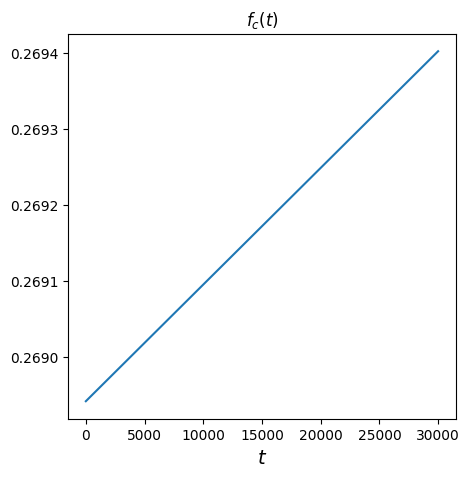

In [6]:
import matplotlib.pyplot as plt

t_c = 12800000
max_t = 30000
maximum_scale = 1
fvals = np.linspace(0, maximum_scale + 0.2, 100)
x = np.linspace(0, max_t, max_t+1)

wc = 12
sigma = 0.05
slope = 1

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x, fc(x, t_c, maximum_scale=maximum_scale, slope=slope))
ax.set_title(r"$f_c(t)$")
ax.set_xlabel(r"$t$", fontsize=14)

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# for t in [0, 100, 200, 300]:
#     y = compute_f_distribution(fvals, t, t_c, wc=wc, sigma=sigma, maximum_scale=maximum_scale, slope=slope)
#     axes[1].plot(fvals, y, label=f"t={t}")
# axes[1].legend()

# axes[1].set_title(r"$p(f; t)$, $t_c=$" + f"{t_c}", fontsize=14)
# axes[1].set_xlabel(r"$f$", fontsize=14)



# Experiments
Engineering work:
 - initialized all sigmoid outputs to be small, i.e. zero bias.

In [116]:
# EXPERIMENT 0: vanilla training, ordinary FFNN. No CV. curriculum learning.
import time
    
# simulation parameters, baseline probabilities, at the f=1 point
n = 4
p1_base = 0.1
p2_base = 0.07
print("Optimal decoding accuracy: ", optimal_decoding(n, p1_base, p2_base))
pcm = repetition_pcm(n)

# # # # # # # # # # # # Parameters # # # # # # # # # # # # # # # #
# Always these with the overfitting experiment to confirm that learning capacity is there!
HIDDEN_DIM = 16
N_LAYERS = 4

# # # # # # # # # # # # Hyperparameters # # # # # # # # # # # # # # # #
max_epochs = 3000
batch_size = 512
learning_rate = 0.01 # make this larger if you increase batch size

# # # # # # # # # # # # Curriculum learning parameters # # # # # # # # 
# stochastic scaling
t_c = 200
maximum_scale = 2
fvals = np.linspace(0, maximum_scale + 0.2, 100)
# alpha = 10
# sigma = 0.05
# slope = 1
# scaling_distr = lambda t: compute_f_distribution(
#     fvals, t, t_c, alpha=alpha, sigma=sigma, maximum_scale=maximum_scale, slope=slope)

# Linear scaling
max_scaling = 4
offset = 1
# scaling_distr = lambda t: offset + (max_scaling - offset) * t / max_epochs
scaling_distr = lambda t: 1

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# dataset
# n_train_vals = np.logspace(10, 17, 9, base=2).astype(int)
n_train_vals = [batch_size * 10]
results = []

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}
for i, n_train in enumerate(n_train_vals):

    print(i, f"n_train={n_train}...")
    # Loss, optimizer, early stopping
    model = FFNNlayered(input_dim=n-1, hidden_dim=HIDDEN_DIM, output_dim=n, N_layers=N_LAYERS)
    print("model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    criterion = torch.nn.BCELoss 
    criterion = WeightedSequenceLoss(criterion)
    virtual_criterion = torch.nn.BCELoss(reduction="none") # make sure it matches the above

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # early_stopping = utils.EarlyStopping(patience=50) # early stopping is problematic when the dataset fluctuates so much
    min_val_loss = 10

    # Training loop
    for epoch in range(max_epochs):
        
        # Curriculum step: regenerate dataset by sampling f from the above distribution
        # and rescaling p1, p2
        # sample f from the distribution
        # f = np.random.choice(fvals, p=scaling_distr(epoch))
        f = scaling_distr(epoch)
        p1, p2 = f*p1_base, f*p2_base
        
        # Virtual TRAINING: We don't actually need datasets to train the model. Instead,
        # we sample data ccording to the known probability distribution, and then reweight the loss
        # according to a histogram of that sample. The loss re-weighting is O(2^nbits) so this is
        # more efficient whenever that number is much smaller than the expected amount of training data.
        n_batches = n_train // batch_size
        downsampled_weights = np.zeros(2**n)
        X, Y = create_dataset(n)
        
        weights_tensor = torch.tensor(bitstring_prob_v1(Y, n, p1, p2), dtype=torch.float32)  # true distribution of bitstrings  
        train_loss = 0
        # torch.autograd.set_detect_anomaly(True)
        all_batches = []
        for _ in range(n_batches):
            # Sample a virtual batch of data
            Xb, Yb, weightsb, histb = sample_virtual_XY(weights_tensor.numpy(), batch_size, n, pcm)
            # weights and hist are both normalized at this point
            # CAREFUL: the shape of weights varies with each batch; histb is consistently (2**nbits,)
            Xb_tensor = torch.tensor(Xb, dtype=torch.float32)
            Yb_tensor = torch.tensor(Yb, dtype=torch.float32)
            weightsb = torch.tensor(weightsb, dtype=torch.float32)
            downsampled_weights += histb
            all_batches.append((Xb_tensor, Yb_tensor, weightsb))
        
        for i, batch in enumerate(all_batches):
            # Sample a virtual batch of data
            Xb, Yb, weightsb = batch
            optimizer.zero_grad()
            Y_pred = model(Xb)
            loss = criterion(Y_pred, Yb, weightsb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / n_batches
        downsampled_weights /= n_batches

        # Virtual Validation
        # 'validation' means evaluating the weighted loss on the true distribtion
        # a model trained in this way cannot be any _worse_ than a model without that validiation scheme!
        # WITH RESPECT TO ORIGINAL PROBABILITIES
        X, Y = create_dataset(n)
        # weights =  bitstring_prob_v1(Y, n, p1, p2)
        Xtensor = torch.tensor(X, dtype=torch.float32)
        Ytensor = torch.tensor(Y.copy(), dtype=torch.float32)
        downsampled_weights_tensor = torch.tensor(downsampled_weights, dtype=torch.float32)

        model.eval()        
        val_acc = weighted_test_acc(model, Xtensor, Ytensor, weights_tensor)
        val_loss = weighted_test_loss(model, Xtensor, Ytensor, weights_tensor)        
        train_acc = weighted_test_acc(model, Xtensor, Ytensor, downsampled_weights_tensor) # training accuracy is evaluated on the same data from this epoch.

        if (epoch % 10) == 0:
            # Saving and printing
            save_str = ""
            if val_loss < min_val_loss:
                torch.save(model.state_dict(), 'checkpoint.pt')
                min_val_loss = val_loss
                save_str = " (Saved)"
            print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}" + save_str)

        history.get("train_loss").append(train_loss)
        history.get("val_loss").append(val_loss)
        history.get("train_acc").append(train_acc)
        history.get("val_acc").append(val_acc)
        
        # early_stopping(val_loss, model)
        # if early_stopping.early_stop:
        #     print("Early stopping")
        #     # raise GetOutOfLoop
        #     break
        if epoch == max_epochs - 1:
            print("Max epochs reached")
                

    # EVALUATION
    # Load the last best model for evaluation
    model.load_state_dict(torch.load('checkpoint.pt'))
    X_test, Y_test = create_dataset(n)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test.copy(), dtype=torch.float32)
    Y_train = sample_bitstring_v1(n, p1_base, p2_base, n_train).astype(int)
    X_train = (Y_train @ repetition_pcm(n).T % 2).astype(int)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

    # train a lookup table on the same dataset
    lookup = LookupTable(n)
    lookup.train(X_train, Y_train)
    lookup_train_acc = compute_decoding_acc(lookup.predict(X_train), Y_train)
    # lookup_test_acc = compute_decoding_acc(lookup.predict(X_test), Y_test)
    # lookup_test_acc = compute_weighted_decoding_acc(lookup, n, p1, p2)

    model.eval()
    with torch.no_grad():
        train_acc = evaluate_model(model, X_train_tensor, Y_train_tensor, print_results=False)
        test_acc = evaluate_model(model, X_test_tensor, Y_test_tensor, print_results=False)
        weighted_acc = weighted_test_acc(model, n, p1_base, p2_base)
        print(f"  Train Accuracy: {train_acc}")
        print(f"  Test Accuracy: {test_acc}")
        print(f"  Weighted Test Accuracy: {weighted_acc}")
        print(f"  Lookup Table Train Accuracy: {lookup_train_acc}")
        print(f"  Lookup Table Test Accuracy: {lookup_test_acc}")

    results.append((unique_errors_seen, train_acc.item(), test_acc.item(), weighted_acc, lookup_train_acc, lookup_test_acc))
    print()
    print()


Optimal decoding accuracy:  0.98208
0 n_train=5120...
model parameters:  948
Epoch 1/3000 | Train Loss: 0.5420 | Val Loss: 0.4047 | Train Acc: 0.7139 | Val Acc: 0.7006 (Saved)
Epoch 11/3000 | Train Loss: 0.1612 | Val Loss: 0.1454 | Train Acc: 0.6953 | Val Acc: 0.7006 (Saved)
Epoch 21/3000 | Train Loss: 0.0397 | Val Loss: 0.0472 | Train Acc: 0.7068 | Val Acc: 0.7006 (Saved)
Epoch 31/3000 | Train Loss: 0.0379 | Val Loss: 0.0398 | Train Acc: 0.6938 | Val Acc: 0.7006 (Saved)
Epoch 41/3000 | Train Loss: 0.0395 | Val Loss: 0.0384 | Train Acc: 0.6986 | Val Acc: 0.7006 (Saved)
Epoch 51/3000 | Train Loss: 0.0413 | Val Loss: 0.0380 | Train Acc: 0.6992 | Val Acc: 0.7006 (Saved)
Epoch 61/3000 | Train Loss: 0.0305 | Val Loss: 0.0381 | Train Acc: 0.6992 | Val Acc: 0.7006
Epoch 71/3000 | Train Loss: 0.0344 | Val Loss: 0.0378 | Train Acc: 0.7061 | Val Acc: 0.7006 (Saved)
Epoch 81/3000 | Train Loss: 0.0424 | Val Loss: 0.0383 | Train Acc: 0.7010 | Val Acc: 0.7006
Epoch 91/3000 | Train Loss: 0.0362 | Val

KeyboardInterrupt: 

In [104]:
X, Y = create_dataset(n)
# weights =  bitstring_prob_v1(Y, n, p1, p2)
Xtensor = torch.tensor(X, dtype=torch.float32)
Ytensor = torch.tensor(Y.copy(), dtype=torch.float32)
downsampled_weights_tensor = torch.tensor(downsampled_weights, dtype=torch.float32)

model.eval()        
val_acc = weighted_test_acc(model, Xtensor, Ytensor, weights_tensor)
val_loss = weighted_test_loss(model, Xtensor, Ytensor, weights_tensor)        
train_acc = weighted_test_acc(model, Xtensor, Ytensor, downsampled_weights_tensor) # training accuracy is evaluated on the same data from this epoch.


In [115]:
Ypred_tensor = model(Xtensor)
for (x, y, yp) in zip(Xtensor, Ytensor, Ypred_tensor):
    print(x.detach().numpy(), y.detach().numpy(), yp.detach().numpy().round(5), yp.int().detach().numpy())

[0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0.] [0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 0. 0. 1.] [0.0e+00 0.0e+00 9.0e-05 0.0e+00 0.0e+00 0.0e+00 7.1e-04 1.0e+00] [0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 1. 1.] [0. 0. 0. 0. 0. 0. 1. 0.] [0.00e+00 0.00e+00 3.00e-04 0.00e+00 0.00e+00 0.00e+00 1.00e+00 1.92e-03] [0 0 0 0 0 0 1 0]
[0. 0. 0. 0. 1. 1. 0.] [0. 0. 0. 0. 0. 1. 0. 0.] [0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.30e-04 1.00e+00 9.10e-04 1.65e-03] [0 0 0 0 0 1 0 0]
[0. 0. 0. 1. 1. 0. 0.] [0. 0. 0. 0. 1. 0. 0. 0.] [0.00e+00 0.00e+00 6.53e-03 0.00e+00 1.00e+00 7.00e-05 0.00e+00 0.00e+00] [0 0 0 0 1 0 0 0]
[0. 0. 1. 1. 0. 0. 0.] [0. 0. 0. 1. 0. 0. 0. 0.] [1.295e-02 9.000e-05 3.700e-04 1.000e+00 0.000e+00 3.700e-03 1.220e-03
 2.800e-04] [0 0 0 1 0 0 0 0]
[0. 1. 1. 0. 0. 0. 0.] [0. 0. 1. 0. 0. 0. 0. 0.] [0.e+00 3.e-05 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00] [0 0 1 0 0 0 0 0]
[1. 1. 0. 0. 0. 0. 0.] [0. 1. 0. 0. 0. 0. 0. 0.] [4.00e-05 1.00e+00 0.00e+00

In [ ]:


        Y_train = sample_bitstring_v1(n, p1, p2, n_train).astype(int)
        X_train = (Y_train @ repetition_pcm(n).T % 2).astype(int)
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

        train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size)
        # FIXME:
        unique_errors_seen = len(np.unique(Y_train, axis=0))

        # Train loop: We don't evaluate training loss the cheap way, because using
        # weighted loss would not give the same training dynamics as using an 
        # actual dataset.
        model.train()
        train_loss = 0.0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, Y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_loader)

In [15]:
# EXPERIMENT 1: vanilla training, ordinary FFNN. Doesn't work, because its not clear that CV is doing anything.
import time
    
# simulation parameters
n = 8
p1 = 0.1
p2 = 0.07

# dataset
n_train_vals = np.logspace(10, 17, 9, base=2).astype(int)
n_train_vals = [10000]
results = []
for i, n_train in enumerate(n_train_vals):
    print(i, f"n_train={n_train}...")
    Y_train = sample_bitstring_v1(n, p1, p2, n_train).astype(int)
    X_train = (Y_train @ repetition_pcm(n).T % 2).astype(int)

    # Assuming X_train and Y_train are your numpy arrays
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

    # count the unique syndromes seen
    unique_errors_seen = len(np.unique(Y_train, axis=0))

    # Hyperparameters
    max_epochs = 200
    batch_size = 16
    k_folds = 6
    learning_rate = 0.0005

    # Loss and optimizer
    model = FFNNlayered(input_dim=n-1, hidden_dim=128, output_dim=n, N_layers=5)
    criterion = torch.nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    

    # Setup K-Fold cross-validation
    kf = KFold(n_splits=k_folds, shuffle=True)
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
        print(f"Fold {fold+1}/{k_folds}")

        # Early stopping is evaluated with respect to each fold, since we 
        # need the model to see the new data each time.
        early_stopping = utils.EarlyStopping(patience=10)

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        
        train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), 
                                batch_size=batch_size, sampler=train_subsampler)
        val_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), 
                                batch_size=batch_size, sampler=val_subsampler)
        
        # Training loop
        for epoch in range(max_epochs):
            model.train()
            train_loss = 0.0
            for X_batch, Y_batch in train_loader:
                optimizer.zero_grad()
                # t0 = time.time()
                output = model(X_batch)
                # t1 = time.time()
                loss = criterion(output, Y_batch)
                # t2 = time.time()
                loss.backward()
                optimizer.step()
                # t3 = time.time()
                # print("forward", t1-t0, "between", t2 - t1, "backward", t3-t2)
                train_loss += loss.item()
            train_loss = train_loss / len(train_loader)
            # Validation loop
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, Y_batch in val_loader:
                    output = model(X_batch)
                    loss = criterion(output, Y_batch)
                    val_loss += loss.item()
            val_loss = val_loss / len(val_loader)

            # Evaluation
            train_acc = evaluate_model(model, X_train_tensor[train_idx], Y_train_tensor[train_idx], print_results=False)
            val_acc = evaluate_model(model, X_train_tensor[val_idx], Y_train_tensor[val_idx], print_results=False)

            # Monitor training and validation loss, printing only to the 4th decimal place
            print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
            early_stopping(val_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                # raise GetOutOfLoop
                break
            if epoch == max_epochs - 1:
                print("Max epochs reached")


    # EVALUATION
    # Load the last best model for evaluation
    model.load_state_dict(torch.load('checkpoint.pt'))
    X_test, Y_test = create_dataset(n)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test.copy(), dtype=torch.float32)

    # train a lookup table on the same dataset
    lookup = LookupTable(n)
    lookup.train(X_train, Y_train)
    lookup_train_acc = compute_decoding_acc(lookup.predict(X_train), Y_train)
    # lookup_test_acc = compute_decoding_acc(lookup.predict(X_test), Y_test)
    lookup_test_acc = compute_weighted_decoding_acc(lookup, n, p1, p2)

    model.eval()
    with torch.no_grad():
        train_acc = evaluate_model(model, X_train_tensor, Y_train_tensor, print_results=False)
        test_acc = evaluate_model(model, X_test_tensor, Y_test_tensor, print_results=False)
        weighted_acc = weighted_test_acc(model, n, p1, p2)
        print(f"  Train Accuracy: {train_acc}")
        print(f"  Test Accuracy: {test_acc}")
        print(f"  Weighted Test Accuracy: {weighted_acc}")
        print(f"  Lookup Table Train Accuracy: {lookup_train_acc}")
        print(f"  Lookup Table Test Accuracy: {lookup_test_acc}")


    results.append((unique_errors_seen, train_acc.item(), test_acc.item(), weighted_acc, lookup_train_acc, lookup_test_acc))
    print()
    print()


0 n_train=10000...
Fold 1/6
Epoch 1/200 | Train Loss: 0.1977 | Val Loss: 0.0614 | Train Acc: 0.4906 | Val Acc: 0.5081
Epoch 2/200 | Train Loss: 0.0432 | Val Loss: 0.0249 | Train Acc: 0.4906 | Val Acc: 0.5081
Epoch 3/200 | Train Loss: 0.0228 | Val Loss: 0.0137 | Train Acc: 0.4906 | Val Acc: 0.5081
Epoch 4/200 | Train Loss: 0.0162 | Val Loss: 0.0142 | Train Acc: 0.4906 | Val Acc: 0.5081
Epoch 5/200 | Train Loss: 0.0128 | Val Loss: 0.0098 | Train Acc: 0.5476 | Val Acc: 0.5633
Epoch 6/200 | Train Loss: 0.0103 | Val Loss: 0.0128 | Train Acc: 0.5430 | Val Acc: 0.5615
Epoch 7/200 | Train Loss: 0.0096 | Val Loss: 0.0082 | Train Acc: 0.5821 | Val Acc: 0.5921
Epoch 8/200 | Train Loss: 0.0082 | Val Loss: 0.0068 | Train Acc: 0.6735 | Val Acc: 0.6881
Epoch 9/200 | Train Loss: 0.0070 | Val Loss: 0.0067 | Train Acc: 0.6735 | Val Acc: 0.6881
Epoch 10/200 | Train Loss: 0.0067 | Val Loss: 0.0085 | Train Acc: 0.7083 | Val Acc: 0.7199
Epoch 11/200 | Train Loss: 0.0062 | Val Loss: 0.0059 | Train Acc: 0.767

C:\Users\peter\AppData\Local\Temp\ipykernel_16496\572539799.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


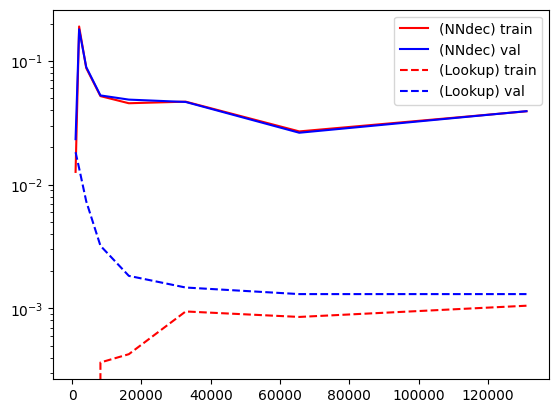

In [129]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
results = np.array(results)
# save the results
np.save("results.npy", results)

# fracs_seen = results[:,0]/2**n
# weighted_fracs_seen = np.multiply(results[:,0], [comb(n, k)*(pavg**k) * (1-pavg)**k for k in range(n+1)])

x = n_train_vals[:-1]
train_accs = results[:,1]
val_accs = results[:,3]
lookup_train_accs = results[:,4]
lookup_test_accs = results[:,5]
ax.plot(x, 1 - train_accs, c='r', label='(NNdec) train')
ax.plot(x, 1 - val_accs, c='b', label='(NNdec) val')

ax.plot(x, 1 - lookup_train_accs, c='r', ls='--', label='(Lookup) train')
ax.plot(x, 1 - lookup_test_accs, c='b', ls='--', label='(Lookup) val')

ax.semilogy()
ax.legend()

In [52]:
results

[(49, 0.521484375, 0.0078125, 0.5277386277),
 (74, 0.556640625, 0.0078125, 0.5453299152900001),
 (90, 0.682373046875, 0.01953125, 0.6737463146970001),
 (115, 0.790283203125, 0.02734375, 0.782812297755),
 (124, 0.83563232421875, 0.05078125, 0.8422317580590001),
 (151, 0.7637939453125, 0.02734375, 0.765221010165),
 (160, 0.8675994873046875, 0.04296875, 0.866859560685),
 (179, 0.8872604370117188, 0.05859375, 0.887817782889),
 (197, 0.8904380798339844, 0.0625, 0.8899678291500001)]

In [46]:
results[0][0]()

0.4931640625

In [ ]:
# Experiment 2: CV, but leave ALL out

# simulation parameters
n = 8
p1 = 0.1
p2 = 0.07

# dataset
n_train = 2 ** 14
Y_train = sample_bitstring_v1(n, p1, p2, n_train).astype(int)
X_train = (Y_train @ repetition_pcm(n).T % 2).astype(int)

# Assuming X_train and Y_train are your numpy arrays
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

model = FFNNlayered(input_dim=n-1, hidden_dim=64, output_dim=n, N_layers=5)

# Hyperparameters
num_epochs = 20
batch_size = 128
k_folds = 10
learning_rate = 0.001

# Loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Setup K-Fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True)
X_train_unique, counts_unique = np.unique(X_train, axis=0, return_counts=True)
# issue: This basically exponentially increases the concentration on the least likely bitstrings
# (those having n/2 bitflips). If there's not good resolution between the more/less likely
# elements within that set, 
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_unique)):
    print(f"Fold {fold+1}/{k_folds}")
    
    # reconstruct 

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), 
                              batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), 
                            batch_size=batch_size, sampler=val_subsampler)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, Y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output, Y_batch)
                val_loss += loss.item()

        # Monitor training and validation loss
        print(f"Epoch {epoch+1}: Train Loss: {train_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")


In [ ]:
# evaluate the model on the test set
X_test, Y_test = create_dataset(n)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.copy(), dtype=torch.float32)

model.eval()
with torch.no_grad():
    train_acc = evaluate_model(model, X_train_tensor, Y_train_tensor, print_results=False)
    test_acc = evaluate_model(model, X_test_tensor, Y_test_tensor, print_results=False)

    print(f"Train Accuracy: {train_acc}")
    print(f"Test Accuracy: {test_acc}")
    print(f"Weighted Test Accuracy: {weighted_test_acc(model, n, p1, p2)}")

# print(train_preds[:10])

Train Accuracy: 0.93206787109375
Test Accuracy: 0.09375


In [ ]:
err = np.array([1, 0, 0, 0], dtype=np.uint8)
H = repetition_pcm(4)
H.dot(err) % 2

array([1, 0, 0], dtype=int32)

In [ ]:
# We need some way of teaching the NN to do decoding on the set of syndromes
# for all errors with weight < n/2 (strictly, even n).

---

